<a href="https://colab.research.google.com/github/Nirzu97/pyprobml/blob/multi-gpu-training-torch/notebooks/multi_gpu_training_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Train a CNN on multiple GPUs using data parallelism.

Based on sec 12.5 of http://d2l.ai/chapter_computational-performance/multiple-gpus.html.

Note: in colab, we only have access to 1 GPU, so the code below just simulates the effects of multiple GPUs, so it will not run faster. You may not see a speedup eveen on a machine which really does have multiple GPUs, because the model and data are too small. But the example should still illustrate the key ideas.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython import display 

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms

import random
import os
import time

np.random.seed(seed=1)
torch.manual_seed(1)
!mkdir figures # for saving plots

# Model

We use a slightly modified version of the LeNet CNN.

In [ ]:
# Initialize model parameters
scale = 0.01
torch.random.manual_seed(0)
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

# Define the model
def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

# Cross-entropy loss function
loss = nn.CrossEntropyLoss(reduction='none')

# Copying parameters across devices

In [ ]:
def get_params(params, device):
    new_params = [p.clone().to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params

In [ ]:
# Copy the params to GPU0
gpu0 = torch.device('cuda:0')
new_params = get_params(params, gpu0)
print('b1 weight:', new_params[1])
print('b1 grad:', new_params[1].grad)

b1 weight: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 grad: None


In [ ]:
# Copy the params to GPU1
gpu1 = torch.device('cuda:0') # torch.device('cuda:1')
new_params = get_params(params, gpu1)
print('b1 weight:', new_params[1])
print('b1 grad:', new_params[1].grad)

b1 weight: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 grad: None


All-reduce will copy data (eg gradients) from all devices to device 0, add them, and then broadcast the result back to each device.

In [ ]:
def allreduce(data):
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)):
        data[i] = data[0].to(data[i].device)

def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
      return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [ ]:
data_ = [torch.ones((1, 2), device=try_gpu(i)) * (i + 1) for i in range(2)]
print('before allreduce:\n', data_[0], '\n', data_[1])
allreduce(data_)
print('after allreduce:\n', data_[0], '\n', data_[1])

before allreduce:
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]])
after allreduce:
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]])


# Distribute data across GPUs

In [ ]:
data_ = torch.arange(20).reshape(4, 5)
#devices = [torch.device('cuda:0'), torch.device('cuda:1')]
devices = [torch.device('cuda:0'), torch.device('cuda:0')]
split = nn.parallel.scatter(data_, devices)
print('input :', data_)
print('load into', devices)
print('output:', split)

input : tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [device(type='cuda', index=0), device(type='cuda', index=0)]
output: (tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0'), tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:0'))


Split data and labels.

In [ ]:

def split_batch(X, y, devices):
    """Split `X` and `y` into multiple devices."""
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices), nn.parallel.scatter(y, devices))

# Training on Fashion MNIST

In [ ]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="../data",
                                                    train=True,
                                                    transform=trans,
                                                    download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data",
                                                   train=False,
                                                   transform=trans,
                                                   download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=4),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=4))

In [ ]:
class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats('svg')
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Timer:
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [ ]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [ ]:
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = torch.argmax(y_hat, axis=1)
    cmp_ = y_hat.type(y.dtype) == y
    return float(cmp_.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

## Train function

In [ ]:
def sgd(params, lr, batch_size):
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [ ]:
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)
    # Loss is calculated separately on each GPU
    losses = [
        loss(lenet(X_shard, device_W),
             y_shard).sum() for X_shard, y_shard, device_W in zip(
                 X_shards, y_shards, device_params)]
    for l in losses:  # Back Propagation is performed separately on each GPU
        l.backward()
    # Sum all gradients from each GPU and broadcast them to all GPUs
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce([device_params[c][i].grad for c in range(len(devices))])
    # The model parameters are updated separately on each GPU
    ndata = X.shape[0] # gradient is summed over the full minibatch
    for param in device_params:
        sgd(param, lr, ndata)   

In [ ]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = load_data_fashion_mnist(batch_size)
    devices = [try_gpu(i) for i in range(num_gpus)]
    # Copy model parameters to num_gpus GPUs
    device_params = [get_params(params, d) for d in devices]
    # num_epochs, times, acces = 10, [], []
    num_epochs = 5
    animator = Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # Perform multi-GPU training for a single minibatch
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()
        # Verify the model on GPU 0
        animator.add(epoch + 1, (evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')

# Learning curve

test acc: 0.74, 4.4 sec/epoch on [device(type='cuda', index=0)]


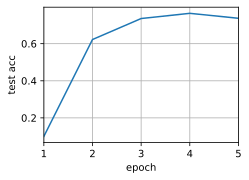

In [ ]:
train(num_gpus=1, batch_size=256, lr=0.2)